# Imports

---

In [116]:
import os

import cv2
import numpy as np
from common_functions import *
from skimage.filters import threshold_minimum,threshold_otsu
from skimage.exposure import equalize_hist
from scipy.ndimage import binary_erosion,binary_closing,binary_opening,binary_dilation
from skimage import morphology
from skimage import exposure
from skimage.measure import find_contours
from skimage.draw import rectangle
from PIL import Image


# Utils
---

In [6]:


def Erode(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Fit=np.all(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Fit
    return Final

def Dilate(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Hit=np.any(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Hit
    return Final 
def custom_erosion (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_erosion = np.zeros(image.shape)

    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_erosion[y,x] = np.all(multiplied_img == 1) 
    return out_image_erosion 


def custom_dilation (image , window_size ):
    height ,  width  = image.shape 
    edge_y = window_size[0] // 2
    edge_x = window_size[1] // 2 
    window = np.ones(window_size) 
    out_image_dilation = np.zeros(image.shape)
    for y in range(edge_y , height - edge_y) :
        for x in range(edge_x , width - edge_x) :
            image_window = image [y-edge_y:y+edge_y+1,x-edge_x:x+edge_x+1] 
            multiplied_img = image_window*window
            out_image_dilation[y,x] = np.any(multiplied_img == 1) 
    return out_image_dilation
def Gamma_correction(img,gamma):
    img = img / img.max()
    img = img* 255
    img = img.astype(np.uint8)
    img = exposure.adjust_gamma(img, gamma)
    return img

def houghTransform(img):
    orgimg=img.copy()
    cdst = orgimg.copy()
    cdstP = np.copy(cdst)
    
    lines = cv2.HoughLines(orgimg, 1, np.pi / 180, 150, None, 0, 0)
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cdst, pt1, pt2, (255,255,255), 2, cv2.LINE_AA)
    
    
    linesP = cv2.HoughLinesP(orgimg, 1, np.pi / 180, 50, None, 50, 60)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255,255,255), 2, cv2.LINE_AA)
    
    return cdstP

# Window size can be rectangle (not equal sides)
def erosion(image: np.ndarray, size_y: int = 3, size_x: int = 3):
    window = np.ones((size_y, size_x))
    rows, cols = image.shape
    edge_x = size_x // 2
    edge_y = size_y // 2
    size_y_odd, size_x_odd = size_y % 2 != 0, size_x % 2 != 0
    threshold = threshold_otsu(image)
    binary_img = image > threshold 

    output_img = np.zeros(binary_img.shape)
    for row in range(edge_y, rows - edge_y):
        for col in range(edge_x, cols - edge_x):
            output_img[row, col] = np.all(binary_img[row - edge_y: row + edge_y + size_y_odd, col - edge_x: col + edge_x + size_x_odd] * window)

    return output_img

# Window size can be rectangle (not equal sides)
def dialation(image: np.ndarray, size_y: int = 3, size_x: int = 3):
    window = np.ones((size_y, size_x))
    rows, cols = image.shape
    edge_x = size_x // 2
    edge_y = size_y // 2
    size_y_odd, size_x_odd = size_y % 2 != 0, size_x % 2 != 0
    threshold = threshold_otsu(image)
    binary_img = image > threshold 

    output_img = np.zeros(binary_img.shape)
    for row in range(edge_y, rows - edge_y):
        for col in range(edge_x, cols - edge_x):
            output_img[row, col] = np.any(binary_img[row - edge_y: row + edge_y + size_y_odd, col - edge_x: col + edge_x + size_x_odd] * window)

    return output_img

## `load_image`

### Description
Load an image from the specified path and fix its orientation.
orientation values:
    # 1 = Horizontal (normal)
    # 2 = Mirror horizontal
    # 3 = Rotate 180
    # 4 = Mirror vertical
    # 5 = Mirror horizontal and rotate 270 CW
    # 6 = Rotate 90 CW
    # 7 = Mirror horizontal and rotate 90 CW
    # 8 = Rotate 270 CW

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`image`** *(ndarray)*: Image.

---


In [7]:
def load_image(image_path: str) -> np.ndarray:
    """
    Load an image from the specified path and fix its orientation.
    orientation values:
        # 1 = Horizontal (normal)
        # 2 = Mirror horizontal
        # 3 = Rotate 180
        # 4 = Mirror vertical
        # 5 = Mirror horizontal and rotate 270 CW
        # 6 = Rotate 90 CW
        # 7 = Mirror horizontal and rotate 90 CW
        # 8 = Rotate 270 CW
    Parameters:
    image_path (str): Path to the image file.
    
    Returns:
    numpy.ndarray: Image array.
    """
    image = Image.open(image_path)
    exif = image._getexif()  # Get EXIF data

    if exif:
        orientation = exif.get(274)  # Orientation tag is 274
        if orientation:
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
            elif orientation == 2:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            elif orientation == 4:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            elif orientation == 5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT).rotate(270, expand=True)
            elif orientation == 7:
                image = image.transpose(Image.FLIP_LEFT_RIGHT).rotate(90, expand=True)
    return np.array(image)

## `load_and_preprocess_image`
### Description
Loads the image, converts it to grayscale, and applies gamma correction.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`image`** *(ndarray)*: Original image.
- **`gray`** *(ndarray)*: Grayscale version of the image.
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

---


In [27]:
def load_and_preprocess_image(image):
    """Loads the image, converts it to grayscale, and applies gamma correction."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = Gamma_correction(gray, 1.5)
    return gray, gray_image

## `reduce_noise`
### Description
Applies noise reduction techniques to the grayscale image.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`blurred`** *(ndarray)*: Noise-reduced grayscale image.

---


In [9]:
def reduce_noise(gray_image):
    """Applies noise reduction techniques to the grayscale image."""
    blurred = cv2.bilateralFilter(gray_image, 80, 50, 5)
    blurred = cv2.GaussianBlur(blurred, (11, 11), 0)
    return blurred


## `threshold_and_edge_detection`
### Description
Applies thresholding and edge detection to preprocess the image for contour detection.

### Parameters
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

### Returns
- **`edges`** *(ndarray)*: Image with edges highlighted after thresholding and dilation.

---

In [10]:

def threshold_and_edge_detection(gray_image):
    """Applies thresholding and edge detection to preprocess the image for contour detection."""
    threshold = threshold_minimum(gray_image)
    mask = gray_image > threshold
    binary_image = np.zeros(gray_image.shape)
    binary_image[mask] = 255
    binary_image = binary_image.astype(np.uint8)
    edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
    return Dilate(edges, 5)

## `filter_reciept_contours`
### Description
Filters contours to find a rectangular contour with 4 corners and a large area.

### Parameters
- **`contours`** *(list)*: List of contours detected in the image.

### Returns
- **`rectangular_contours`** *(list)*: Contours that are rectangular.
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept with the largest area.

---


In [11]:

def filter_reciept_contours(contours):
    """Filters contours to find a rectangular contour with 4 corners and a large area."""
    # rectangular_contours = []
    max_area = 0
    reciept_contour = None
    for contour in contours:
        # x, y, w, h = cv2.boundingRect(contour)
        # aspect_ratio = w / h
        # print(aspect_ratio)
        area = cv2.contourArea(contour)
        if area > max_area:
            peri = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
            print(len(approx_polygon))
            if area > max_area and len(approx_polygon) == 4:
                # rectangular_contours.append(approx_polygon)
                reciept_contour = approx_polygon
                max_area = area
    return reciept_contour

In [12]:

def process_image_iteration(preProcessedImage, edges, iterations):
    """Processes the image for a given iteration using various transformations."""
    if iterations == 0:
        return cv2.dilate(edges, np.ones((60, 60)))
    elif iterations == 0 or iterations == 1:
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
        return cv2.erode(preProcessedImage, np.ones((3, 3)))
    elif iterations == 2:
        return houghTransform(preProcessedImage)
    else:
        preProcessedImage = houghTransform(preProcessedImage)
        preProcessedImage = cv2.erode(preProcessedImage, np.ones((3, 3)))
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
        preProcessedImage = cv2.dilate(preProcessedImage, np.ones((7, 7)))
        return cv2.erode(preProcessedImage, np.ones((7, 7)))

## `apply_iterations`
### Description
Iteratively processes the image using various transformations until contours are found.

### Parameters
- **`preProcessedImage`** *(ndarray)*: Image to process during iterations.
- **`edges`** *(ndarray)*: Image with detected edges.

### Returns
- **`preProcessedImage`** *(ndarray)*: Processed image after iterations.
- **`contours`** *(list)*: List of contours detected in the processed image.

---

In [13]:

def apply_iterations(preProcessedImage, edges):
    """Iteratively processes the image using various transformations until contours are found."""
    for iterations in range(8):
        preProcessedImage = process_image_iteration(preProcessedImage, edges, iterations)

        if preProcessedImage.dtype != np.uint8:
            preProcessedImage = (preProcessedImage * 255).astype(np.uint8)
        
        show_images([preProcessedImage], ["Iteration " + str(iterations)])

        contours, _ = cv2.findContours(preProcessedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        reciept_contour = filter_reciept_contours(contours)
        if len(reciept_contour) > 0:
            return reciept_contour

    return None


## `find_polygon_corners`
### Description
Identifies the corners of the detected polygon.

### Parameters
- **`reciept_contour`** *(ndarray)*: Contour of the detected reciept.

### Returns
- **`input_points`** *(ndarray)*: Array containing the four corner points of the detected polygon.

---

In [14]:

def find_polygon_corners(reciept_contour):
    """Identifies the corners of the detected polygon."""
    points = reciept_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]
    return input_points

## `transform_perspective`
### Description
Performs a perspective transformation on the image.

### Parameters
- **`image`** *(ndarray)*: Original image.
- **`input_points`** *(ndarray)*: Four corner points of the detected polygon.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept.

---


In [15]:

def transform_perspective(image, input_points):
    """Performs a perspective transformation on the image."""
    max_width = 650
    max_height = 1024
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    return img_output

## `find_reciept`
### Description
Main function to detect a reciept in an image and return the transformed perspective.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`img_output`** *(ndarray)*: Perspective-transformed output image of the detected reciept. 
  If no reciept is detected, the original image is returned.

In [139]:
def find_reciept(image):
    """Main function to detect a reciept in an image and return the transformed perspective."""
    gray, gray_image = load_and_preprocess_image(image) # Convert to grayscale and apply gamma correction
    edges = threshold_and_edge_detection(gray_image) # Apply thresholding and edge detection (Heba)
    # preProcessedImage, contours = apply_iterations(edges, edges)
    # reciept_contour = apply_iterations(gray_image, edges)
    
    connected_edges = cv2.dilate(edges, np.ones((60, 60)))
    show_images([connected_edges])
    # thinning
    connected_edges = morphology.thin(connected_edges)
    contours, _ = cv2.findContours(fix_image_type(connected_edges), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    reciept_contour = filter_reciept_contours(contours)

    # contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # reciept_contour = filter_reciept_contours(contours)

    if reciept_contour is None or len(reciept_contour) == 0:
        return image

    input_points = find_polygon_corners(reciept_contour)
    img_output = transform_perspective(image, input_points)
    return img_output


## `find_digits`
### Description
Main functionality is to detect the 16 digits from the receipt.

### Parameters
- **`image`** *(ndarray)*: Input image.

### Returns
- **`img_output`** *(ndarray)*: cropped_image.

In [135]:
def visualize_contours(image, contours):
    """Visualizes the contours on the image."""
    image = image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

def find_digits(image: np.ndarray) -> np.ndarray:
    """Main functionality is to detect the 16 digits from the receipt."""
    height, width, _ = image.shape
    image = image.copy()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) * 255
    smoothed_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # binary_image = cv2.adaptiveThreshold(smoothed_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # binary_image = np.bitwise_not(binary_image)

    binary_image = convert_to_binary(smoothed_image)

    dilation_image = dialation(binary_image, 3, 25)
    erosion_image = erosion(dilation_image, 3, 25)
    show_images([image, binary_image, dilation_image, erosion_image], ["Original", "Binary", "Dilation", "Erosion"])

    dilation_image = fix_image_type(dilation_image)

    # Get the contours of the image
    contours, _ = cv2.findContours(dilation_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(len(contours))

    # Filter the contours to get the 16 digits
    digits_contours = None
    largest_area = 0
    max_aspect_ratio = 0
    max_width = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        area = cv2.contourArea(contour)
        
        ## Testing & Visualizing
        # print(aspect_ratio, area)
        # draw_contour = visualize_contours(image, [contour])
        # show_images([draw_contour], [f"{w}, {h}"])
        # save draw_contour with name of aspect_ratio
        # os.makedirs("aspect_ratios2", exist_ok=True)
        # io.imsave(f"aspect_ratios2/{aspect_ratio}.jpg", draw_contour)
        ## Testing & Visualizing

        # is_between(w, 0.7 * width, 0.8 * width)
        # w > max_width
        # and aspect_ratio > max_aspect_ratio        
        if is_between(w, 0.6 * width, 0.8 * width) and area > largest_area and not is_between(aspect_ratio, 0.5, 1.5): #  and is_between(w, 20, 30) and is_between(h, 40, 50)
            digits_contours = contour
            largest_area = area
            ## Testing & Visualizing
            # draw_contour = visualize_contours(image, [contour])
            # show_images([draw_contour], [f"Aspect Ratio: {aspect_ratio}, Area: {area}"])

    if digits_contours is None:
        return image
    
    # ## Testing & Visualizing
    # show_images([visualize_contours(image, [digits_contours])])
    # ## Testing & Visualizing

    x, y, w, h = cv2.boundingRect(digits_contours)
    x, y, w, h = add_padding(x, y, w, h, padding_x=0, padding_y=4)

    return crop_image(image, x, y, w, h)

# Testing

---

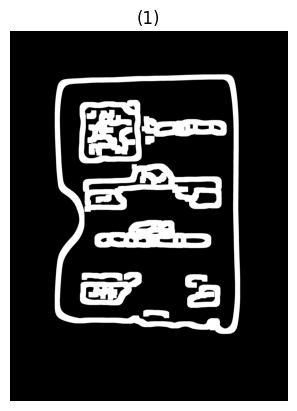

7


TypeError: object of type 'NoneType' has no len()

In [138]:
image = load_image("../imgs/18.jpg")
reciept = find_reciept(image)
show_images([image, reciept], ["Original Image", "Transformed Image"])

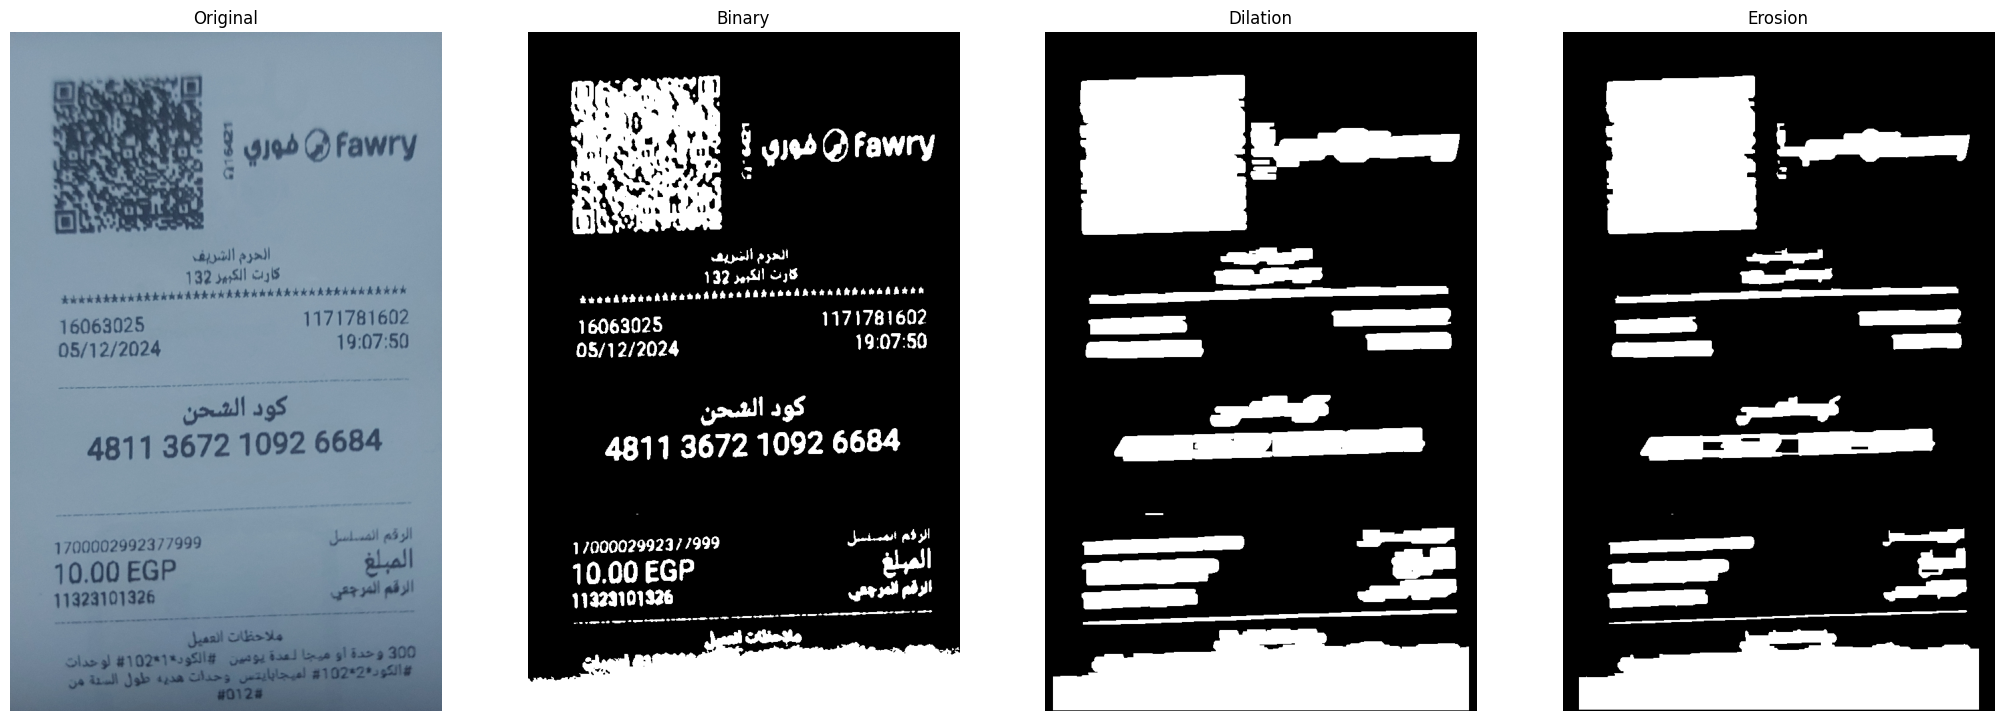

Same Image: False


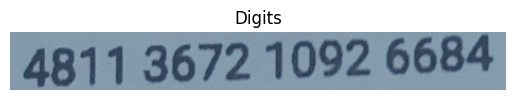

In [136]:
digits = find_digits(reciept.copy())
print(f"Same Image: {reciept.shape == digits.shape}")
show_images([digits], ["Digits"])

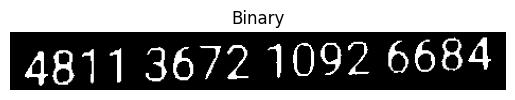

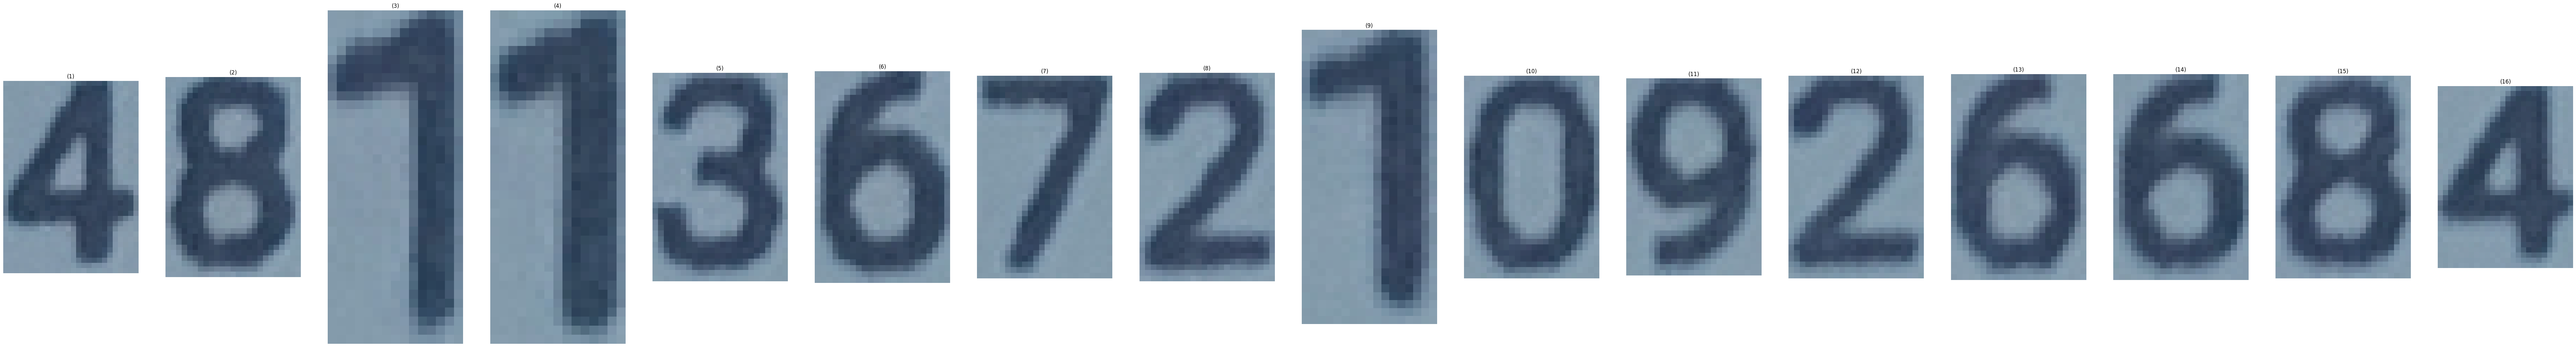

In [137]:
def split_digits(digits: np.ndarray):
    # Convert to grayscale
    gray = cv2.cvtColor(digits, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to create a binary image
    binary = convert_to_binary(gray)
    binary = np.bitwise_not(binary)
    eroded = erosion(binary, 4, 3)

    show_images([eroded], ["Binary"])

    # Find contours
    contours, _ = cv2.findContours(fix_image_type(eroded), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digits_splited = []
    max_height = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x, y, w, h = add_padding(x, y, w, h, padding_x=4, padding_y=5)
        digits_splited.append((crop_image(digits, x, y, w, h), x))
        max_height = max(max_height, h) # Save it to remove small contours

    digits_splited.sort(key=lambda x: x[1])
    digits_splited = [x[0] for x in digits_splited if x[0].shape[0] > 0.5 * max_height]
    return digits_splited

show_images(split_digits(digits))

In [ ]:
base_path = "../imgs/"
min_image_index = 10
max_image_index = 24
for i in range(min_image_index, max_image_index + 1):
    image_path = base_path + str(i) + ".jpg"
    image = load_image(image_path)
    os.makedirs("results", exist_ok=True)
    reciept = find_reciept(image)
    digits = find_digits(reciept)
    digits_splited = split_digits(digits)
    for j, digit in enumerate(digits_splited):
        os.makedirs(f"results/{i}", exist_ok=True)
        io.imsave(f"results/{i}/{j}.jpg", digit)
    print(f"Image {i} done.")
print("All images done.")

# 12 -> Max width!! Solve the issue of the digits (checking height, position)
# 15, 16, 17 -> Strong rotation (Mesamhin)
# 18 -> Detected 6 Corners because of my finger

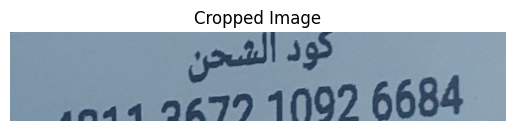

In [21]:
t1 = 660
t2 = 750
croppedReceipt = reciept[t1:t2,100:600].copy()
show_images([croppedReceipt], ["Cropped Image"])

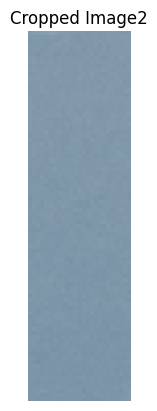

In [22]:
cropped2 = croppedReceipt[:,25:50].copy()
show_images([cropped2], ["Cropped Image2"])

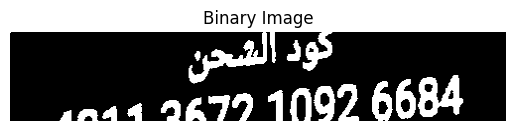

In [23]:
# Required Imports
import numpy as np
import heapq
from skimage import io
from skimage.color import rgba2rgb, rgb2gray  # For image color conversions
from skimage.measure import find_contours  # For contour detection
import matplotlib.pyplot as plt  # For visualization (optional)

"""
Extract individual digit images from an input image.

Parameters:
    img (numpy.ndarray): Input image containing multiple digits.
    
Returns:
    list: A list of images, each containing one digit.
"""
i2 = croppedReceipt.copy()
img = croppedReceipt.copy().astype(np.uint8)  # Ensure image is uint8
img = 1 - img
if len(img.shape) == 3:  # Handle RGB or RGBA images
    if img.shape[2] == 4:  # If RGBA, convert to RGB
        img = rgba2rgb(img)
    img = rgb2gray(img)  # Convert to grayscale

img = img > 0.5  # Binarization (thresholding)

show_images([img], ["Binary Image"])

    
    




In [24]:
from scipy.ndimage import binary_erosion, binary_dilation, binary_opening, binary_closing

Number of contours found: 33
Number of contours after filtering: 9


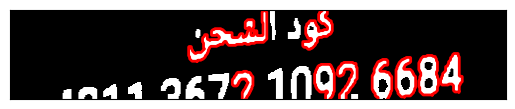

Current min_contour_size: 100
Number of letters: 9
Number of contours found: 33
Number of contours after filtering: 11


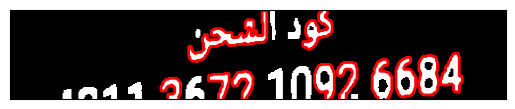

Current min_contour_size: 95
Number of letters: 11
Number of contours found: 33
Number of contours after filtering: 11


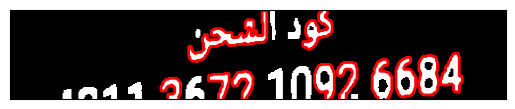

Current min_contour_size: 90
Number of letters: 11
Number of contours found: 33
Number of contours after filtering: 13


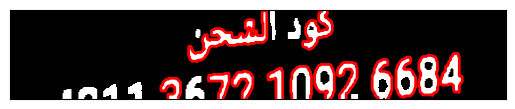

Current min_contour_size: 85
Number of letters: 13
Number of contours found: 33
Number of contours after filtering: 13


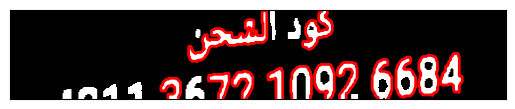

Current min_contour_size: 80
Number of letters: 13
Number of contours found: 33
Number of contours after filtering: 14


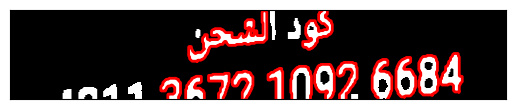

Current min_contour_size: 75
Number of letters: 14
Number of contours found: 33
Number of contours after filtering: 15


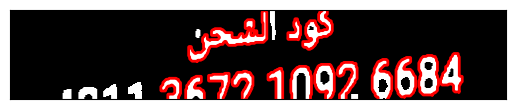

Current min_contour_size: 70
Number of letters: 15
Number of contours found: 33
Number of contours after filtering: 16


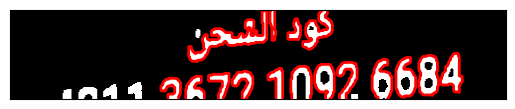

Current min_contour_size: 65
Number of letters: 15
Number of contours found: 33
Number of contours after filtering: 17


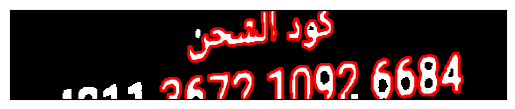

Current min_contour_size: 60
Number of letters: 15
Number of contours found: 33
Number of contours after filtering: 19


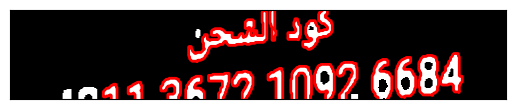

Current min_contour_size: 55
Number of letters: 17


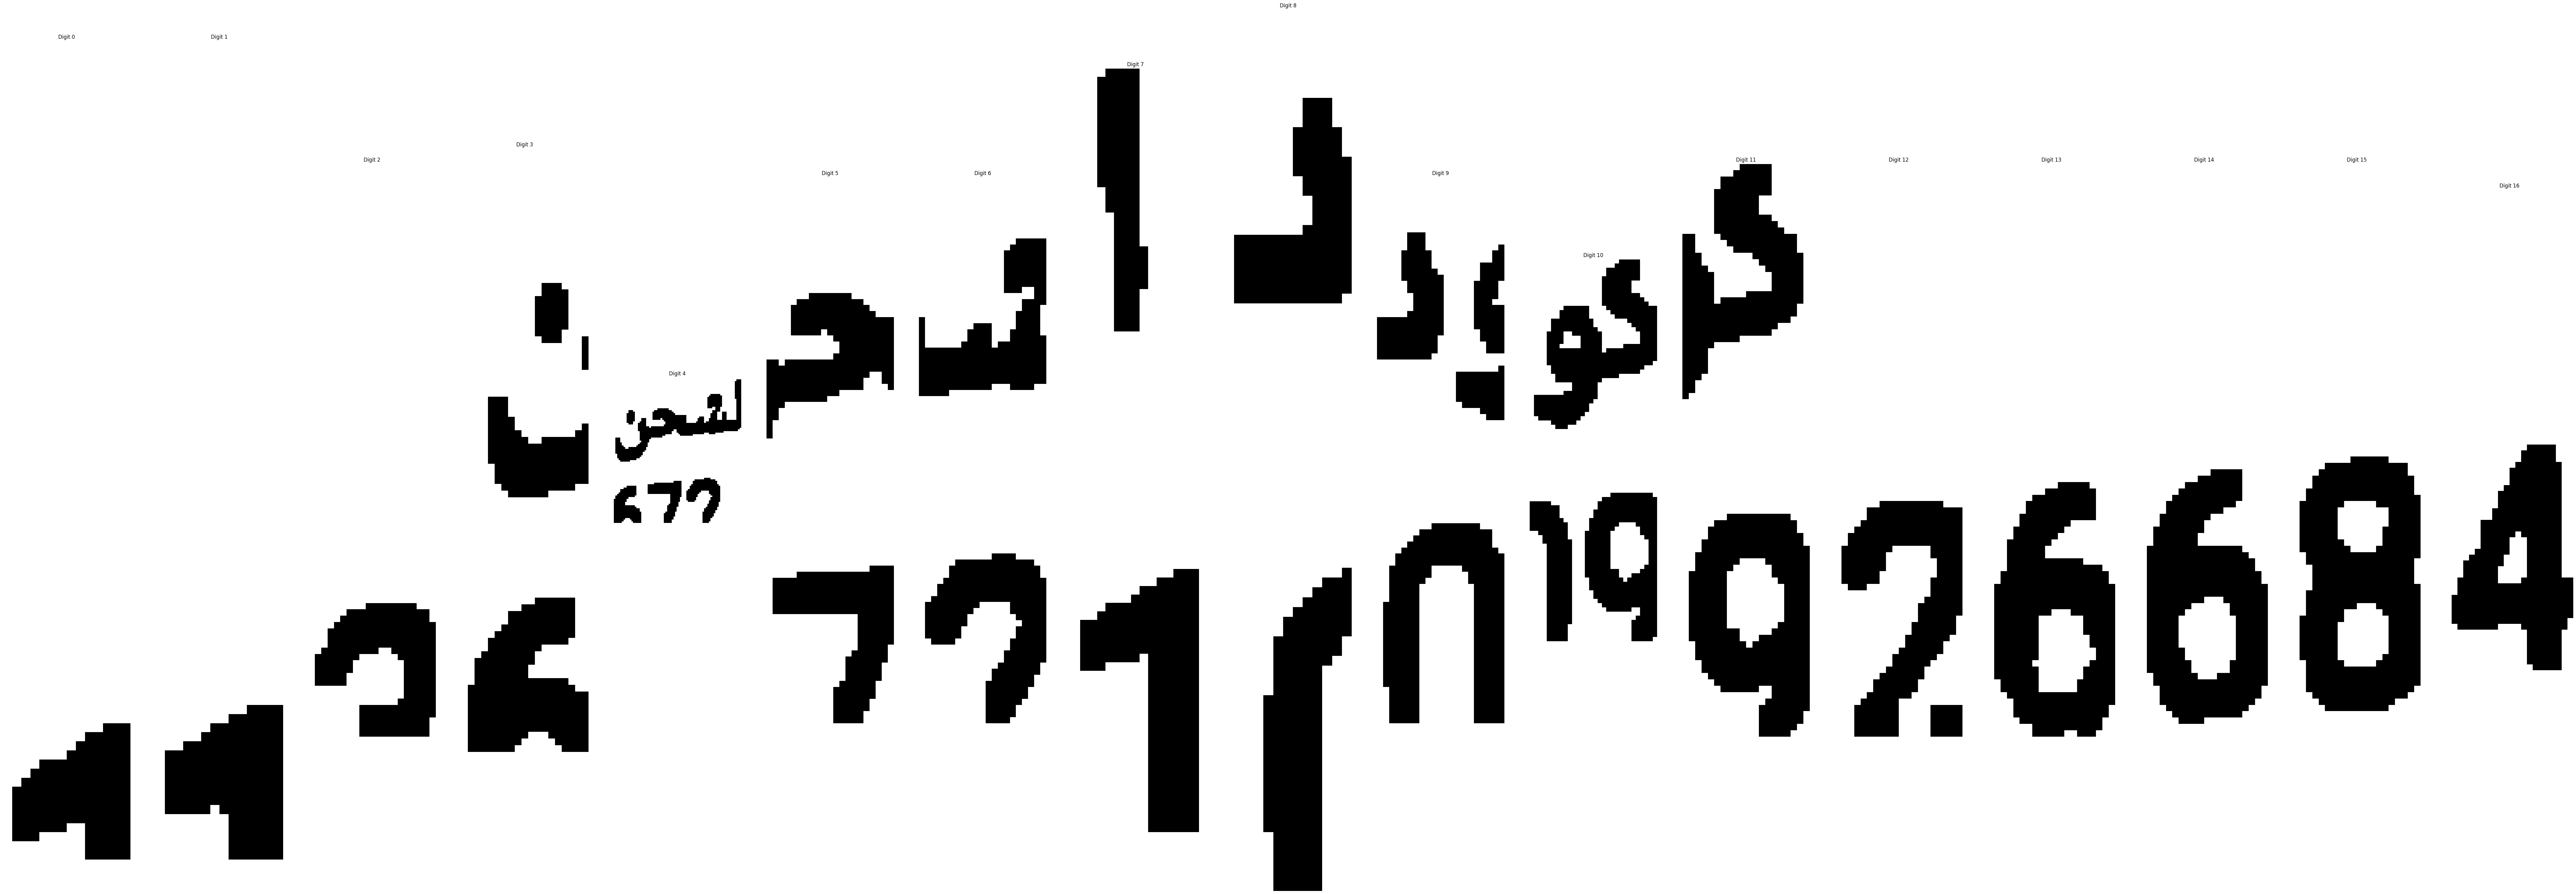

1
17


In [25]:
import cv2
import os
import numpy as np
import heapq
from skimage.measure import find_contours
import matplotlib.pyplot as plt


# Apply erosion
img = binary_opening(img, np.ones((3,2)), iterations=2)

def process_contours(min_contour_size):
    global contours, queue, existing_regions, letters

    # Find contours of the digits
    contours = find_contours(img, 0.6)
    print("Number of contours found:", len(contours))

    # Keep only the big contours
    contours = [contour for contour in contours if contour.shape[0] > min_contour_size]
    print("Number of contours after filtering:", len(contours))

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    queue = []
    existing_regions = []  # To store existing bounding boxes

    # Function to check intersection between bounding boxes
    def intersects(new_box, existing_boxes):
        new_x1, new_y1, new_x2, new_y2 = new_box
        for box in existing_boxes:
            x1, y1, x2, y2 = box
            if not (new_x2 < x1 or new_x1 > x2 or new_y2 < y1 or new_y1 > y2):
                return True  # Intersection found
        return False

    # Extract bounding boxes for contours
    for contour in contours:
        maxY = contour[:, 0].max()
        maxX = contour[:, 1].max()
        minY = contour[:, 0].min()
        minX = contour[:, 1].min()

        # Filter out noise based on width of the contour
        if maxX - minX > 10:
            new_box = (minX, minY, maxX, maxY)
            if not intersects(new_box, existing_regions):
                # Push regions to a heap for sorting by X-coordinate
                heapq.heappush(queue, (minX, img[:, int(minX):int(maxX)]))
                existing_regions.append(new_box)

    # Extract individual digit images
    letters = []
    while len(queue) > 0:
        img_digit = heapq.heappop(queue)[1]  # Extract the digit region
        img_digit = img_digit.astype(np.uint8)
        img_digit = img_digit.max() - img_digit  # Invert colors if necessary
        letters.append(img_digit)  # Append the digit image to the list

# Adjust contour size dynamically to get at least 16 letters
min_contour_size = 100
while True:
    process_contours(min_contour_size)
    print("Current min_contour_size:", min_contour_size)
    print("Number of letters:", len(letters))
    if len(letters) >= 16 or min_contour_size <= 10:
        break
    min_contour_size -= 5  # Reduce the contour size threshold incrementally

# Show extracted digit images
show_images(letters, ["Digit " + str(i) for i in range(len(letters))])
print(letters[0].max())
print(len(letters))


In [26]:
# Required Libraries
import os
import math
import numpy as np
from skimage import io  # For reading images
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.neighbors import KNeighborsClassifier  # k-NN Classifier
from sklearn.metrics import accuracy_score  # For accuracy evaluation

# Dataset Path
dataset_path1 = 'synthetic_digits_cropped'
letters_data1 = []  # Feature vectors
labels1 = []  # Labels (folder names)
minHeight1 = math.inf  # Initialize with infinite height
minWidth1 = math.inf  # Initialize with infinite width

# Find minimum dimensions for resizing
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):  # Ensure it's a directory
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):  # Process PNG files
                image_path = os.path.join(letter_path1, filename)
                img = io.imread(image_path)
                if img.shape[0] < minHeight1:
                    minHeight1 = img.shape[0]
                if img.shape[1] < minWidth1:
                    minWidth1 = img.shape[1]

# Define uniform dimensions for all images
new_dimensions1 = (minWidth1, minHeight1)

# Preprocess images and extract features
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):
                image_path1 = os.path.join(letter_path1, filename)
                original_image1 = io.imread(image_path1)
                img1 = cv2.resize(original_image1, new_dimensions1)  # Resize image

                # Handle RGBA to RGB conversion
                if len(img1.shape) == 3 and img1.shape[2] == 4:
                    img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)

                # Convert to grayscale
                img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
                #show_images([img1], ["Gray Image"])

                # Flatten the image into a feature vector
                flattened_image1 = img1.flatten()
                letters_data1.append(flattened_image1)
                labels1.append(letter_folder1)  # Folder name as label

# Convert lists to NumPy arrays
X1 = np.array(letters_data1)
y1 = np.array(labels1)

# Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=0)

# Initialize and train the k-NN classifier
knn_classifier1 = KNeighborsClassifier(n_neighbors=3)
knn_classifier1.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred1 = knn_classifier1.predict(X_test1)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test1, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")


ModuleNotFoundError: No module named 'sklearn'

In [292]:
import cv2
import numpy as np
import os

def preprocess_image(img, dimensions):
    img_resized = cv2.resize(img, dimensions)
    
    # Convert RGBA to RGB if necessary
    if len(img_resized.shape) == 3 and img_resized.shape[2] == 4:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    #check if the image is already in grayscale
    if len(img_resized.shape) == 3:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_resized
    #show_images([img_gray], ["Gray Image"])

    #now make it binary
    img_binary = np.zeros(img_gray.shape)
    img_binary[img_gray > 0.9] = 255
    #img_binary *= 255
    img_binary = img_binary.astype(np.uint8)
    #show_images([img_binary], ["Binary Image"])
    print(img_gray.max())
    return img_binary

def save_and_preprocess_images(images, dimensions, output_folder):
    """
    Loops through an array of images, preprocesses them, and saves them to a file.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img in enumerate(images):
        # Preprocess image
        img_binary = preprocess_image(img, dimensions)

        # Save the binary image to a file
        output_path = os.path.join(output_folder, f"image_{i}.png")
        cv2.imwrite(output_path, img_binary)
        print(f"Saved: {output_path}")


# Simulated input images (replace with actual images)

output_dir = "output_images1"
dimensions = new_dimensions1  # Resize dimensions (width, height)

# Process images and save
save_and_preprocess_images(letters, dimensions, output_dir)

1
Saved: output_images1\image_0.png
1
Saved: output_images1\image_1.png
1
Saved: output_images1\image_2.png
1
Saved: output_images1\image_3.png
1
Saved: output_images1\image_4.png
1
Saved: output_images1\image_5.png
1
Saved: output_images1\image_6.png
1
Saved: output_images1\image_7.png
1
Saved: output_images1\image_8.png
1
Saved: output_images1\image_9.png
1
Saved: output_images1\image_10.png
1
Saved: output_images1\image_11.png
1
Saved: output_images1\image_12.png
1
Saved: output_images1\image_13.png
1
Saved: output_images1\image_14.png
1
Saved: output_images1\image_15.png


In [293]:
import cv2
import os
import numpy as np

# Template matching function
def match_template(image, templates_folder):
    best_match = None
    highest_corr = -1
    
    for digit in range(10):  # Loop through 0-9 folders
        digit_folder = os.path.join(templates_folder, str(digit))
        
        # Check if the digit folder exists
        if not os.path.exists(digit_folder):
            continue
        
        # Loop through all images inside the current digit folder
        for template_filename in os.listdir(digit_folder):
            template_path = os.path.join(digit_folder, template_filename)
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            
            # Ensure the template and image are the same size
            if image.shape == template_img.shape:
                # Perform template matching using normalized cross-correlation
                result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF_NORMED)
                corr_value = result[0][0]  # Single value since image size == template size

                # Track the best match
                if corr_value > highest_corr:
                    highest_corr = corr_value
                    best_match = str(digit)
    
    return best_match

# Loop through each letter image
predicted_digits = []
templates_folder = "templates2"  # Path to your templates2 folder

for letter_img in letters:
    #show_images([letter_img])  # Display the current letter

    # Preprocess the image (ensure it matches template dimensions)
    processed_img = preprocess_image(letter_img, new_dimensions1)

    # Perform template matching
    predicted_digit = match_template(processed_img, templates_folder)
    predicted_digits.append(predicted_digit)

# Display the result
print("Predicted Digits:", "".join(predicted_digits))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Predicted Digits: 4443478835508717


In [299]:
import os
import math
import numpy as np
from skimage import io  # For reading images
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score  # For accuracy evaluation

# Dataset Path
dataset_path1 = 'templates2'
letters_data1 = []  # Feature vectors
labels1 = []  # Labels (folder names)
minHeight1 = math.inf  # Initialize with infinite height
minWidth1 = math.inf  # Initialize with infinite width

# Step 1: Find minimum dimensions for resizing
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):  # Ensure it's a directory
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):  # Process PNG files
                image_path = os.path.join(letter_path1, filename)
                img = io.imread(image_path)
                if img.shape[0] < minHeight1:
                    minHeight1 = img.shape[0]
                if img.shape[1] < minWidth1:
                    minWidth1 = img.shape[1]

# Define uniform dimensions for all images
new_dimensions1 = (minWidth1, minHeight1)

# Step 2: Preprocess images and extract features
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):
                image_path1 = os.path.join(letter_path1, filename)
                original_image1 = io.imread(image_path1)
                img1 = cv2.resize(original_image1, new_dimensions1)  # Resize image

                # Handle RGBA to RGB conversion
                if len(img1.shape) == 3 and img1.shape[2] == 4:
                    img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)

                # Convert to grayscale
                if len(img1.shape) == 3:  # Check if not already grayscale
                    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

                # Flatten the image into a feature vector
                flattened_image1 = img1.flatten()
                letters_data1.append(flattened_image1)
                labels1.append(letter_folder1)  # Folder name as label

# Convert lists to NumPy arrays
X1 = np.array(letters_data1)
y1 = np.array(labels1)

# Step 3: Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.00001, random_state=0)

# Step 4: Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')  # Linear kernel for simplicity
svm_classifier.fit(X_train1, y_train1)

# Step 5: Make predictions on the test set
y_pred1 = svm_classifier.predict(X_test1)

# Step 6: Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test1, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 0.00%


In [300]:
# Predict digits for the letters array using the trained SVM classifier
predicted_digits = []

for letter_img in letters:
    # Preprocess each letter image to match SVM input format
    img_resized = cv2.resize(letter_img, new_dimensions1)  # Resize to match training size
    img_flattened = img_resized.flatten().reshape(1, -1)  # Flatten and reshape for SVM input
    
    # Predict the digit
    predicted_digit = svm_classifier.predict(img_flattened)
    predicted_digits.append(predicted_digit[0])

# Print the predicted digits
print("Predicted Digits:", "".join(predicted_digits))


Predicted Digits: 8888888888888888


In [287]:
import cv2
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Load Templates and Prepare Training Data
def load_templates(template_folder):
    X, y = [], []
    for label in range(10):
        digit_folder = os.path.join(template_folder, str(label))
        if os.path.exists(digit_folder):
            for filename in os.listdir(digit_folder):
                img = cv2.imread(os.path.join(digit_folder, filename), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (20, 20))  # Resize to fixed dimensions
                X.append(img.flatten())  # Flatten the image
                y.append(label)
    return np.array(X), np.array(y)

# Step 2: Train the k-NN Classifier
template_folder = "templates2"  # Path to the templates folder
X_train, y_train = load_templates(template_folder)

knn = KNeighborsClassifier(n_neighbors=3)  # k = 3
knn.fit(X_train, y_train)

# Step 3: Preprocess Input Image
def preprocess_image(img):
    # Check if the image is already grayscale
    if len(img.shape) == 2:  # Single channel
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh


# Step 4: Detect Contours and Extract Digits
def extract_digits(image, knn):
    preprocessed = preprocess_image(image)
    contours, _ = cv2.findContours(preprocessed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 20:  # Filter small noise
            digit_region = preprocessed[y:y+h, x:x+w]
            digit_resized = cv2.resize(digit_region, (20, 20))  # Resize for consistency
            digit_flattened = digit_resized.flatten().reshape(1, -1)
            predicted_digit = knn.predict(digit_flattened)
            digits.append((x, predicted_digit[0]))  # Store x for sorting

    # Sort digits based on their x-coordinates
    digits = sorted(digits, key=lambda d: d[0])
    return [digit[1] for digit in digits]

# Step 5: Run the Pipeline
#input_image_path = "test_image.jpg"
#image = cv2.imread(input_image_path)
#detected_digits = extract_digits(image, knn)
#print("Detected Digits:", "".join(map(str, detected_digits)))
for letter_img in letters:
    #show_images([letter_img])  # Display the current letter

    # Preprocess the image (ensure it matches template dimensions)
    

    # Perform template matching
    predicted_digit = extract_digits(letter_img, knn)
    if predicted_digit:  # Check if any digit was detected
        predicted_digits.extend([str(d) for d in predicted_digit])

# Display the result
for digit in predicted_digit:
    if isinstance(digit, list):  # Flatten nested lists
        predicted_digits.extend([str(d) for d in digit])
    else:
        predicted_digits.append(str(digit))

print(predicted_digits[0:16])




['5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5']


In [284]:
# Required Libraries
import os
import math
import numpy as np
from skimage import io  # For reading images
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.neighbors import KNeighborsClassifier  # k-NN Classifier
from sklearn.metrics import accuracy_score  # For accuracy evaluation

# Dataset Path
dataset_path1 = 'templates2'
letters_data1 = []  # Feature vectors
labels1 = []  # Labels (folder names)
minHeight1 = math.inf  # Initialize with infinite height
minWidth1 = math.inf  # Initialize with infinite width

# Find minimum dimensions for resizing
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):  # Ensure it's a directory
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):  # Process PNG files
                image_path = os.path.join(letter_path1, filename)
                img = io.imread(image_path)
                if img.shape[0] < minHeight1:
                    minHeight1 = img.shape[0]
                if img.shape[1] < minWidth1:
                    minWidth1 = img.shape[1]

# Define uniform dimensions for all images
new_dimensions1 = (minWidth1, minHeight1)

# Preprocess images and extract features
for letter_folder1 in os.listdir(dataset_path1):
    letter_path1 = os.path.join(dataset_path1, letter_folder1)
    if os.path.isdir(letter_path1):
        for filename in os.listdir(letter_path1):
            if filename.endswith('.png'):
                image_path1 = os.path.join(letter_path1, filename)
                original_image1 = io.imread(image_path1)
                img1 = cv2.resize(original_image1, new_dimensions1)  # Resize image

                # Handle RGBA to RGB conversion
                if len(img1.shape) == 3 and img1.shape[2] == 4:
                    img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)

                # Convert to grayscale
                #check if image is not already in grayscale
                if len(img1.shape) == 3:
                    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

                
                #show_images([img1], ["Gray Image"])

                # Flatten the image into a feature vector
                flattened_image1 = img1.flatten()
                letters_data1.append(flattened_image1)
                labels1.append(letter_folder1)  # Folder name as label

# Convert lists to NumPy arrays
X1 = np.array(letters_data1)
y1 = np.array(labels1)

# Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.001, random_state=0)

# Initialize and train the k-NN classifier
knn_classifier2 = KNeighborsClassifier(n_neighbors=2)
knn_classifier2.fit(X_train1, y_train1)

# Make predictions on the test set
y_pred1 = knn_classifier2.predict(X_test1)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test1, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 100.00%


In [285]:

# Function to preprocess a single image
def preprocess_image(img, dimensions):
    """
    Preprocess the input image to match the training format.
    """
    # Load the image
    #img = io.imread(image_path)
    
    # Resize to the new dimensions
    img_resized = cv2.resize(img, dimensions)
    
    # Convert RGBA to RGB if necessary
    if len(img_resized.shape) == 3 and img_resized.shape[2] == 4:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    #check if the image is already in grayscale
    if len(img_resized.shape) == 3:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_resized
    #show_images([img_gray], ["Gray Image"])

    #now make it binary
    img_gray = img_gray > 0.5
    

    #img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    
    # Flatten the image
    #show_images([img_gray], ["Gray Image"])
    flattened_img = img_gray.flatten()
    
    return flattened_img

# Path to your test image
#test_image_path = 'path/to/your/test_image.png'

# Preprocess the test image
preprocessed_image = preprocess_image(cropped2, new_dimensions1)

# Reshape to 2D array (required for sklearn input)
preprocessed_image = np.array(preprocessed_image).reshape(1, -1)

# Make prediction using the trained k-NN classifier
predicted_label = knn_classifier2.predict(preprocessed_image)

# Display the result
print(f"Predicted Label: {predicted_label[0]}")



Predicted Label: 5


In [286]:

#show_images([letters[0]])
predicted_digits = []
for letter_img in letters:
    #show_images([letter_img])
    # Preprocess each isolated digit image
    processed_img = preprocess_image(letter_img, new_dimensions1)
    #show_images([processed_img*255])
    processed_img = processed_img.reshape(1, -1) 
    #show_images([processed_img]) # Reshape for k-NN input
    
    # Predict the digit using the trained k-NN model
    predicted_digit = knn_classifier2.predict(processed_img)
    predicted_digits.append(predicted_digit[0])

# Display the result
print("Predicted Digits:", "".join(predicted_digits))


Predicted Digits: 5555555555555555


# Extraxct Number
---
(Not finished yet)

In [181]:
'''
grey_card = rgb2gray(reciept)
binary_card = grey_card > 0.5 
negated_binary_card = np.logical_not(binary_card)
dilated_card = custom_dilation(negated_binary_card,(11,11)) 
closing = custom_erosion(negated_binary_card , (3,3))

contours = find_contours(closing , 0.8)  
bounding_boxes =[]
for contour in contours : 
    x_min = np.min(contour[:, 1])
    x_max = np.max(contour[:, 1])
    y_min = np.min(contour[:, 0])
    y_max = np.max(contour[:, 0])

    bounding_box = [x_min, x_max, y_min, y_max]

    horizontal = x_max - x_min
    vertical = y_max - y_min

    detected_aspect_ratio = horizontal/vertical

    if (detected_aspect_ratio >=  2.5) and (detected_aspect_ratio <=  3.5) :
        bounding_boxes.append(bounding_box)
print(len(bounding_boxes))
img_with_boxes = np.zeros_like(closing)
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=grey_card.shape)
    img_with_boxes[rr, cc] = 0 #set color white 
show_images ([reciept, binary_card ,dilated_card, closing,img_with_boxes], ['original_card', 'binary_card' ,'dilated_card', 'closing','img with boxes']) 
'''

"\ngrey_card = rgb2gray(reciept)\nbinary_card = grey_card > 0.5 \nnegated_binary_card = np.logical_not(binary_card)\ndilated_card = custom_dilation(negated_binary_card,(11,11)) \nclosing = custom_erosion(negated_binary_card , (3,3))\n\ncontours = find_contours(closing , 0.8)  \nbounding_boxes =[]\nfor contour in contours : \n    x_min = np.min(contour[:, 1])\n    x_max = np.max(contour[:, 1])\n    y_min = np.min(contour[:, 0])\n    y_max = np.max(contour[:, 0])\n\n    bounding_box = [x_min, x_max, y_min, y_max]\n\n    horizontal = x_max - x_min\n    vertical = y_max - y_min\n\n    detected_aspect_ratio = horizontal/vertical\n\n    if (detected_aspect_ratio >=  2.5) and (detected_aspect_ratio <=  3.5) :\n        bounding_boxes.append(bounding_box)\nprint(len(bounding_boxes))\nimg_with_boxes = np.zeros_like(closing)\n#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes\nfor box in bounding_boxes:\n    [Xmin,